# CompareBoth

In [30]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import seaborn as sns

In [ ]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["Tweet"]

user_collection = db["users"]
user_labeled_svm_collection = db["users_labeled"]
user_predicted_svm_collection = db["users_predicted"]
user_predicted_kmeans_collection = db["users_kmeans_labeled"]

user_compare_both_collection = db["users_compare_both"]

In [ ]:
user_compare_both_collection.drop()

## Fusion des résultats du Kmeans avec SVM dans users_compare_both

### Faire une copie des attributs de users dans users_compare_both

In [ ]:
users = user_collection.find({})
user_compare_both_collection.insert_many(users)

### Merge les données labélisées du SVM dans users_compare_both

In [ ]:
pipeline = [
    {
        '$project': {
            '_id': 1,
            'user_id': 1,
            'label_svm': '$label'
        }
    },
    {
        '$merge': {
            'into': 'users_compare_both',
            'on': '_id',
            'whenMatched': 'merge',
            'whenNotMatched': 'discard'
        }
    }
]

for collection in [user_labeled_svm_collection, user_predicted_svm_collection]:
    collection.aggregate(pipeline)

### Merge les données labélisées du Kmeans dans users_compare_both

On créé des indexes pour merge sur user_id

In [ ]:
user_compare_both_collection.create_index("user_id", unique=True)
user_predicted_kmeans_collection.create_index("user_id", unique=True)

In [ ]:
pipeline = [
    {
        '$project': {
            '_id': 0,
            'user_id': 1,
            'label_kmeans': 1,
            'CP1': 1,
            'CP2': 1,
            'CP3': 1,
            'CP4': 1,
            'CP5': 1
        }
    },
    {
        '$merge': {
            'into': 'users_compare_both',
            'on': 'user_id',
            'whenMatched': 'merge',
            'whenNotMatched': 'discard'
        }
    }
]

user_predicted_kmeans_collection.aggregate(pipeline)

## Visualisations

### Confusion matrix

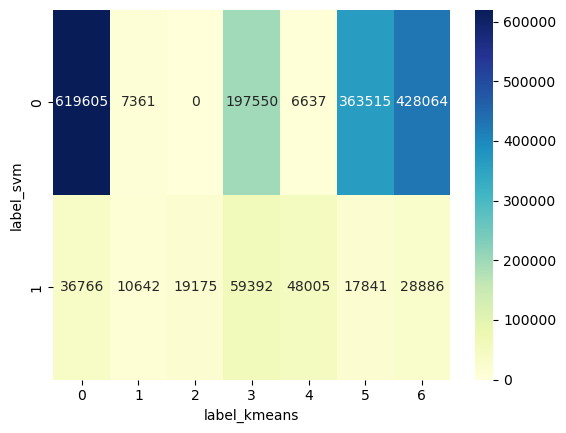

In [33]:
# Créer une matrice de confusion
confusion_matrix = pd.crosstab(users['label_svm'], users['label_kmeans'])

# Créer une heatmap à partir de la matrice de confusion
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='d')

# Configurer les étiquettes des axes
plt.xlabel('label_kmeans')
plt.ylabel('label_svm')

# Afficher la heatmap
plt.show()

### Toutes les combinaisons de 3 attributs

In [ ]:
users = user_compare_both_collection.find({})

In [ ]:
users = pd.DataFrame(list(users))

In [ ]:
attributs_to_drop = ['_id', 'user_id', 'user_id', "last_tweet_published_id","tweet_ids","CP1","CP2","CP3","CP4","CP5","label_kmeans","label_svm"]
X = users.drop(columns=attributs_to_drop)

In [ ]:
Y_SVM = users.label_svm
Y_Kmeans = users.label_kmeans

In [ ]:
attributs = X.columns.to_list()
couples_axes = list(combinations(attributs, 3))

In [ ]:
method = ['SVM', 'Kmeans']
colors = ['blue', 'red', 'pink', 'yellow', 'green', 'black', 'orange']
colors_svm = [colors[label] for label in Y_SVM]
colors_kmeans = [colors[label] for label in Y_Kmeans]

In [ ]:
len(couples_axes)

> Réduire le nombre d'attributs, de combinaisons & Mettre à jour la légende pour le Kmeans

In [ ]:
for i, couple in enumerate(couples_axes):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 50), subplot_kw={'projection': '3d'})
    x = X[couple[0]]
    y = X[couple[1]]
    z = X[couple[2]]
    for j, colors in enumerate([colors_svm, colors_kmeans]):
        subplot_index = j
        ax = axes.flatten()[subplot_index]

        ax.scatter(x, y, z, c=colors)

        ax.set_xlabel(couple[0])
        ax.set_ylabel(couple[1])
        ax.set_zlabel(couple[2])

        title = f"{method[j]} ({couple[0]}, {couple[1]}, {couple[2]})"
        ax.set_title(title)

        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Normaux', markerfacecolor='blue', markersize=8),
                           plt.Line2D([0], [0], marker='o', color='w', label='Atypiques', markerfacecolor='red', markersize=8)]
        ax.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()